lifetimes Quickstart
https://lifetimes.readthedocs.io/en/latest/Quickstart.html

In [51]:
# similar API to scikit-learn and lifelines.
from lifetimes.datasets import load_cdnow_summary
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions

#transaction data examples
from lifetimes.datasets import load_transaction_data
from lifetimes.utils import summary_data_from_transaction_data

from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

from lifetimes.plotting import plot_history_alive

from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value

from lifetimes import GammaGammaFitter

In [2]:
data = load_cdnow_summary(index_col=[0])
data.head()

,frequency,recency,T
ID,,,
1,2,30.43,38.86
2,1,1.71,38.86
3,0,0.00,38.86
4,0,0.00,38.86
5,0,0.00,38.86


* **frequency** represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. This is actually slightly wrong. It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.

* **T** represents the age of the customer in whatever time units chosen (weekly, in the above dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.
recency represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

* **monetary_value** represents the average value of a given customer’s purchases. This is equal to the sum of all a customer’s purchases divided by the total number of purchases. Note that the denominator here is different than the frequency described above.

In [5]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
bgf

<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.79, alpha: 4.41, b: 2.43, r: 0.24>

# Basic Frequency/Recency analysis using the BG/NBD model


https://lifetimes.readthedocs.io/en/latest/lifetimes.html?highlight=betageofitter#lifetimes.BetaGeoFitter

In [6]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.242593,0.012557,0.217981,0.267205
alpha,4.413532,0.378221,3.672218,5.154846
a,0.792886,0.185719,0.428877,1.156895
b,2.425752,0.705345,1.043276,3.808229


In [22]:
bgf.params_

r        0.242593
alpha    4.413532
a        0.792886
b        2.425752
dtype: float64

# Visualizing our Frequency/Recency Matrix


<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

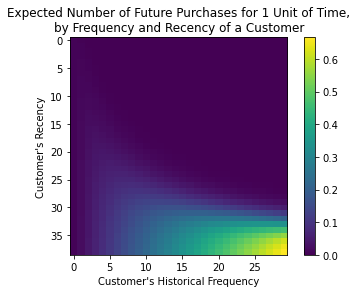

In [13]:
plot_frequency_recency_matrix(bgf)

https://lifetimes.readthedocs.io/en/latest/lifetimes.html?highlight=plot_frequency#lifetimes.plotting.plot_frequency_recency_matrix

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

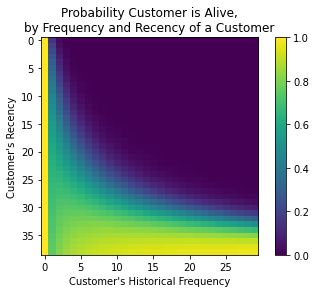

In [15]:
plot_probability_alive_matrix(bgf)

# Ranking customers from best to worst


In [20]:
t=1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t,data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,predicted_purchases
ID,,,,
509,18,35.14,35.86,0.424877
841,19,34.00,34.14,0.474738
1981,17,28.43,28.86,0.486526
157,29,37.71,38.00,0.662396
1516,26,30.86,31.00,0.710623


Great, we can see that the customer who has made 26 purchases, and bought very recently from us, is probably going to buy again in the next period.

# Assessing model fit

<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

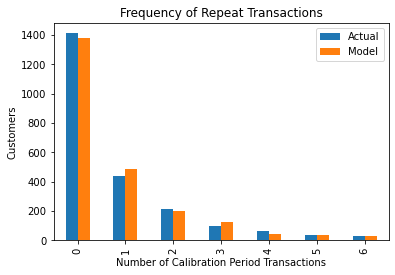

In [25]:
plot_period_transactions(bgf)

model_fit_1

We can see that our actual data and our simulated data line up well. This proves that our model doesn’t suck.

# Example using transactional datasets


In [28]:
transaction_data = load_transaction_data()
transaction_data.head()

,date,id
0,2014-03-08 00:00:00,0
1,2014-05-21 00:00:00,1
2,2014-03-14 00:00:00,2
3,2014-04-09 00:00:00,2
4,2014-05-21 00:00:00,2


In [30]:
summary = summary_data_from_transaction_data(transaction_data, 'id', 'date', observation_period_end='2014-12-31')
summary.head()

,frequency,recency,T
id,,,
0,0.0,0.0,298.0
1,0.0,0.0,224.0
2,6.0,142.0,292.0
3,0.0,0.0,147.0
4,2.0,9.0,183.0


In [31]:
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 5000 subjects, a: 1.85, alpha: 1.86, b: 3.18, r: 0.16>

In [32]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.163851,0.003987,0.156036,0.171666
alpha,1.864281,0.095386,1.677325,2.051237
a,1.850343,0.129584,1.596358,2.104328
b,3.181059,0.293578,2.605645,3.756472


# More model fitting

With transactional data, we can partition the dataset into a calibration period dataset and a holdout dataset. This is important as we want to test how our model performs on data not yet seen (think cross-validation in standard machine learning literature). Lifetimes has a function to partition our dataset like this:

In [35]:
summary_cal_holdout = calibration_and_holdout_data(transaction_data, 'id', 'date',
                                                   calibration_period_end='2014-09-01',
                                                   observation_period_end='2014-12-31')
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
id,,,,,
0,0.0,0.0,177.0,0.0,121.0
1,0.0,0.0,103.0,0.0,121.0
2,6.0,142.0,171.0,0.0,121.0
3,0.0,0.0,26.0,0.0,121.0
4,2.0,9.0,62.0,0.0,121.0


<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

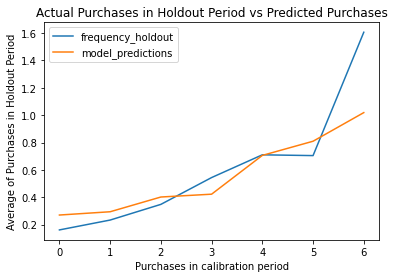

In [37]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

# Customer Predictions

In [38]:
t = 10 #predict purchases in 10 periods
individual = summary.iloc[20]
# the below function is an alias to 'bgf.conditional_expected_number_of_purchases_up_to_time'
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])


0.05765116591827169

# Customer Probability Histories

ConversionError: Failed to convert value(s) to axis units: '2014-06-30 00:00:00'

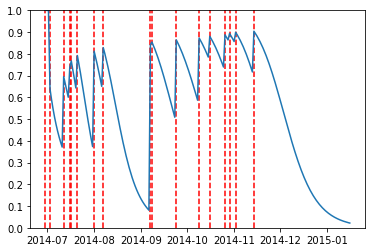

In [41]:
id = 35
days_since_birth = 200
sp_trans = transaction_data.loc[transaction_data['id'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'date')

In [42]:
# should be in 'Jul 2014' format
# should have legend blue is 'P_alive' and red is purchases
# y axis is P_alive

# Estimating customer lifetime value using Gamma-Gamma model

In [49]:
summary_with_money_value = load_cdnow_summary_data_with_monetary_value()
summary_with_money_value.head()


,frequency,recency,T,monetary_value
customer_id,,,,
1,2,30.43,38.86,22.35
2,1,1.71,38.86,11.77
3,0,0.00,38.86,0.00
4,0,0.00,38.86,0.00
5,0,0.00,38.86,0.00


# returning customers have frequency > 0

In [48]:
returning_customers_summary = summary_with_money_value[summary_with_money_value['frequency']>0]
returning_customers_summary.head()

,frequency,recency,T,monetary_value
customer_id,,,,
1,2,30.43,38.86,22.35
2,1,1.71,38.86,11.77
6,7,29.43,38.86,73.74
7,1,5.00,38.86,11.77
9,2,35.71,38.86,25.55


If computing the monetary value from your own data, note that it is the mean of a given customer’s value, not the sum. monetary_value can be used to represent profit, or revenue, or any value as long as it is consistently calculated for each customer.

# The Gamma-Gamma model and the independence assumption

The model we are going to use to estimate the CLV for our userbase is called the Gamma-Gamma submodel, which relies upon an important assumption. The Gamma-Gamma submodel, in fact, assumes that there is no relationship between the monetary value and the purchase frequency. In practice we need to check whether the **Pearson correlation** between the two vectors is close to 0 in order to use this model.

In [50]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.113884
frequency,0.113884,1.000000


At this point we can train our Gamma-Gamma submodel and predict the conditional, expected average lifetime value of our customers.

In [53]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
       returning_customers_summary['monetary_value'])
ggf

<lifetimes.GammaGammaFitter: fitted with 946 subjects, p: 6.25, q: 3.74, v: 15.45>

In [54]:
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,6.248802,1.189687,3.917016,8.580589
q,3.744588,0.290166,3.175864,4.313313
v,15.447748,4.159994,7.294160,23.601336


we can now estimate the average transactin value

In [55]:
ggf.conditional_expected_average_profit(
    summary_with_money_value['frequency'],
    summary_with_money_value['monetary_value']).head(10)

customer_id
1     24.658616
2     18.911480
3     35.171002
4     35.171002
5     35.171002
6     71.462851
7     18.911480
8     35.171002
9     27.282408
10    35.171002
dtype: float64

https://lifetimes.readthedocs.io/en/latest/lifetimes.html?highlight=profit#lifetimes.GammaGammaFitter.conditional_expected_average_profit

In [57]:
print('Expected conditional average profit: %s, Average profit: %s' %(
    ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']).mean(),
        summary_with_money_value[summary_with_money_value['frequency']>0]['monetary_value'].mean()))

Expected conditional average profit: 35.25295817605008, Average profit: 35.07855179704026


While for computing the total CLV using the DCF method (https://en.wikipedia.org/wiki/Discounted_cash_flow) adjusting for cost of capital:

In [59]:
bgf.fit(summary_with_money_value['frequency'], summary_with_money_value['recency'],summary_with_money_value['T'])

ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    summary_with_money_value['frequency'],
    summary_with_money_value['recency'],
    summary_with_money_value['T'],
    summary_with_money_value['monetary_value'], 
    time=12, #months
    discount_rate=0.01 # monthly discount rate ~12.7 annually
).head(10)

customer_id
1      140.096218
2       18.943466
3       38.180575
4       38.180575
5       38.180575
6     1003.868285
7       28.109681
8       38.180575
9      167.418224
10      38.180575
Name: clv, dtype: float64